## Process Visiopharm output

- 40 brains embedded, sectioned, stained, and mounted onto slides
- 8x5 grid per slide (n=8 conditions, n=5 per condition, n=5 stains), ~9000 sections
- GFAP and Iba1 = 210 um between slides; TH, TPH, and KOR = 420 um between slides
- brains were not embedded perfectly so there is some rostral-caudal variability (see example slide below)

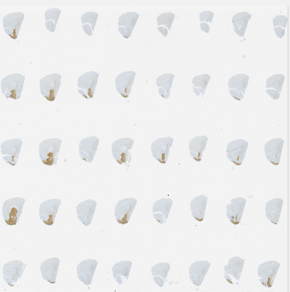

- train supervised ML algo to predict Allen Brain Atlas slide number
- Schindler lab reserach assistants labeled 400+ sections as training data

In [52]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics

import shap
# load JS visualization code to notebook
shap.initjs()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', None)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Create data frame

#### Get data

In [2]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/TH_Section_210123.xlsx'

data = pd.read_excel(path)
data = pd.DataFrame(data = data)
print(data.shape)
print(data.columns)

data.head()

(1000, 13)
Index(['Measurement', 'Details', 'Section_OriH', 'Section_OriV', 'Section_Sol', 'Section_Convex', 'Section_FF', 'Section_Eccen', 'Section_Elip', 'Section_perim', 'Section_minoraxis', 'Section_majoraxis', 'Section_area'], dtype='object')


,Measurement,Details,Section_OriH,Section_OriV,Section_Sol,Section_Convex,Section_FF,Section_Eccen,Section_Elip,Section_perim,Section_minoraxis,Section_majoraxis,Section_area
0,11,"(A, 1)",1.319256,-0.251540,0.977267,0.954286,0.781693,0.553853,0.788865,13924.576172,3342.055420,4820.875977,12064248.0
1,11,"(A, 2)",1.254310,-0.316486,0.979163,0.934949,0.789401,0.469058,0.863651,14880.006836,3757.840576,4817.838379,13915438.0
2,11,"(A, 3)",1.385192,-0.185604,0.976787,0.937947,0.765246,0.526211,0.799442,14325.690430,3461.870850,4787.528809,12500922.0
3,11,"(A, 4)",1.213539,-0.357257,0.982862,0.938007,0.765206,0.561686,0.806560,15358.500000,3597.972168,5256.278320,14371628.0
4,11,"(A, 5)",1.181550,-0.389246,0.972883,0.952619,0.780957,0.541501,0.763743,13932.301758,3358.845947,4752.342773,12065061.0


In [3]:
#fix TH measurement variables
data['Measurement'] = [str('TH_' + str(x)) if len(str(x)) < 3 else x for x in data['Measurement']]
#add stain column
data['Stain'] = [x.split('_')[0] for x in data['Measurement'].values]
data['Slide'] = [x.split('_')[1] for x in data['Measurement'].values]
data['Letter'] = [x.split(',')[0].split('(')[1] for x in data['Details'].values]
data['Number'] = [int(x.split(',')[1].split(')')[0]) for x in data['Details'].values]

data.drop(['Measurement', 'Details'], axis=1, inplace=True)

print(data.shape)
data.head()

(1000, 15)


,Section_OriH,Section_OriV,Section_Sol,Section_Convex,Section_FF,Section_Eccen,Section_Elip,Section_perim,Section_minoraxis,Section_majoraxis,Section_area,Stain,Slide,Letter,Number
0,1.319256,-0.251540,0.977267,0.954286,0.781693,0.553853,0.788865,13924.576172,3342.055420,4820.875977,12064248.0,TH,11,A,1
1,1.254310,-0.316486,0.979163,0.934949,0.789401,0.469058,0.863651,14880.006836,3757.840576,4817.838379,13915438.0,TH,11,A,2
2,1.385192,-0.185604,0.976787,0.937947,0.765246,0.526211,0.799442,14325.690430,3461.870850,4787.528809,12500922.0,TH,11,A,3
3,1.213539,-0.357257,0.982862,0.938007,0.765206,0.561686,0.806560,15358.500000,3597.972168,5256.278320,14371628.0,TH,11,A,4
4,1.181550,-0.389246,0.972883,0.952619,0.780957,0.541501,0.763743,13932.301758,3358.845947,4752.342773,12065061.0,TH,11,A,5


#### Get labels

In [4]:
#create list of dir paths

orig_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels'

dir_path_list = os.listdir(orig_path)

labels_dir_paths = []
for directory in dir_path_list:
    int_path = orig_path + '/' + directory
    labels_dir_paths.append(int_path)
    
labels_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Katrina.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Emma.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Saiyara.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Harmanjit.xlsx']

In [5]:
labels_final = pd.DataFrame()

for path in labels_dir_paths:

    if path.split('/')[-1] == '.DS_Store':
        pass 
    else:
        labels_int = pd.read_excel(path)
        labels_int = pd.DataFrame(data = labels_int)
        print(labels_int.shape)
        print(labels_int.columns)
    
        if labels_final.shape[0] < 1:
            labels_final = labels_int
        else: 
            labels_final = pd.concat([labels_final, labels_int], axis=0)
    
    print(labels_final.shape, '\n')
    
labels_final.head()

(0, 0) 

(8, 15)
Index(['Letter', 'Number', 'Slide_11', 'Slide_13', 'Slide_15', 'Slide_17', 'Slide_19', 'Slide_21', 'Slide_23', 'Slide_25', 'Slide_27', 'Slide_29', 'Slide_31', 'Slide_33', 'Slide_35'], dtype='object')
(8, 15) 

(8, 15)
Index(['Letter', 'Number', 'Slide_11', 'Slide_13', 'Slide_15', 'Slide_17', 'Slide_19', 'Slide_21', 'Slide_23', 'Slide_25', 'Slide_27', 'Slide_29', 'Slide_31', 'Slide_33', 'Slide_35'], dtype='object')
(16, 15) 

(8, 15)
Index(['Letter', 'Number', 'Slide_11', 'Slide_13', 'Slide_15', 'Slide_17', 'Slide_19', 'Slide_21', 'Slide_23', 'Slide_25', 'Slide_27', 'Slide_29', 'Slide_31', 'Slide_33', 'Slide_35'], dtype='object')
(24, 15) 

(8, 15)
Index(['Letter', 'Number', 'Slide_11', 'Slide_13', 'Slide_15', 'Slide_17', 'Slide_19', 'Slide_21', 'Slide_23', 'Slide_25', 'Slide_27', 'Slide_29', 'Slide_31', 'Slide_33', 'Slide_35'], dtype='object')
(32, 15) 



,Letter,Number,Slide_11,Slide_13,Slide_15,Slide_17,Slide_19,Slide_21,Slide_23,Slide_25,Slide_27,Slide_29,Slide_31,Slide_33,Slide_35
0,A,3,36,44,53,64,70,76,82,92,104,115,122,130,none
1,B,3,38,47,55,65,71,76,84,92,103,115,121,129,none
2,C,3,34,43,53,61,69,75,84,90,102,110,120,129,none
3,D,3,37,46,53,66,72,76,82,90,104,115,122,130,none
4,E,3,37,44,52,62,70,76,82,90,103,112,119,128,none


In [6]:
labels_final.drop(['Slide_35'], axis=1, inplace=True)

slides = ['Slide_11', 'Slide_13', 'Slide_15', 'Slide_17', 'Slide_19', 'Slide_21', 'Slide_23', 'Slide_25', 
          'Slide_27', 'Slide_29', 'Slide_31', 'Slide_33']

labels_final_melt = pd.melt(labels_final, id_vars=['Letter', 'Number'], value_vars=slides,
              var_name='Slide', value_name='ABA_slide')

labels_final_melt['ABA_slide'] = [int(x) for x in labels_final_melt['ABA_slide']]
                                                              
labels_final_melt['Slide'] = labels_final_melt['Slide'].str.lstrip('Slide_')
print(labels_final_melt.shape)
labels_final_melt.head()

(384, 4)


,Letter,Number,Slide,ABA_slide
0,A,3,11,36
1,B,3,11,38
2,C,3,11,34
3,D,3,11,37
4,E,3,11,37


#### Combine

In [7]:
data_final = labels_final_melt.merge(data, on=['Letter', 'Number', 'Slide'], how='outer')
print(data_final.shape)
data_final.head()

(1000, 16)


,Letter,Number,Slide,ABA_slide,Section_OriH,Section_OriV,Section_Sol,Section_Convex,Section_FF,Section_Eccen,Section_Elip,Section_perim,Section_minoraxis,Section_majoraxis,Section_area,Stain
0,A,3,11,36.0,1.385192,-0.185604,0.976787,0.937947,0.765246,0.526211,0.799442,14325.690430,3461.870850,4787.528809,12500922.0,TH
1,B,3,11,38.0,1.261347,-0.309450,0.979034,0.934325,0.763451,0.548761,0.818679,14636.612305,3462.779297,4954.887695,13019320.0,TH
2,C,3,11,34.0,1.293674,-0.277122,0.985566,0.948724,0.803895,0.538238,0.845022,13428.011719,3273.165771,4608.145996,11541783.0,TH
3,D,3,11,37.0,1.479231,-0.091565,0.956915,0.933021,0.737761,0.533011,0.807646,14768.431641,3499.296387,4887.974121,12798137.0,TH
4,E,3,11,37.0,1.019552,-0.551244,0.988907,0.969083,0.645562,0.585325,0.478364,14316.309570,3454.672607,4748.321289,12029688.0,TH


### Explore features

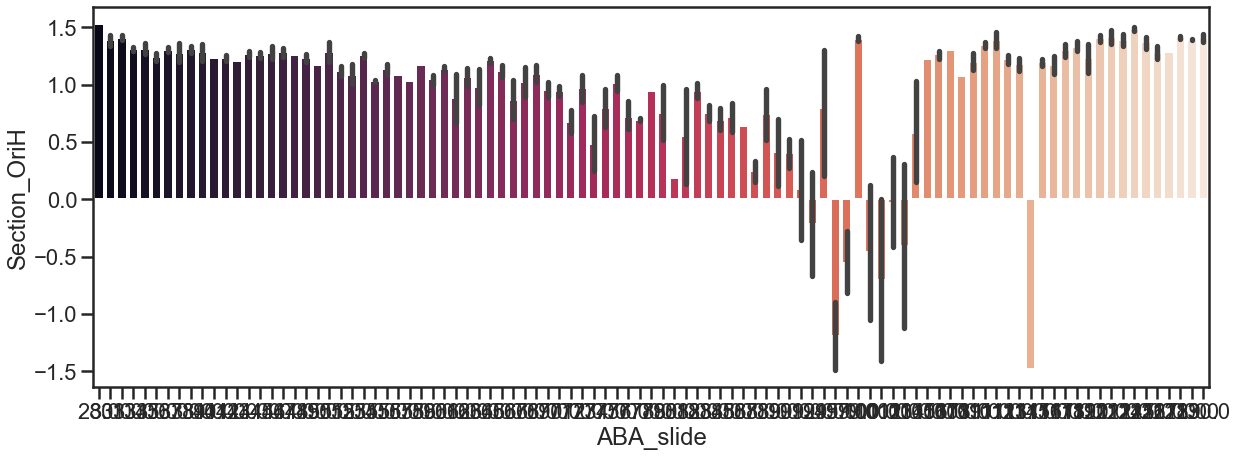

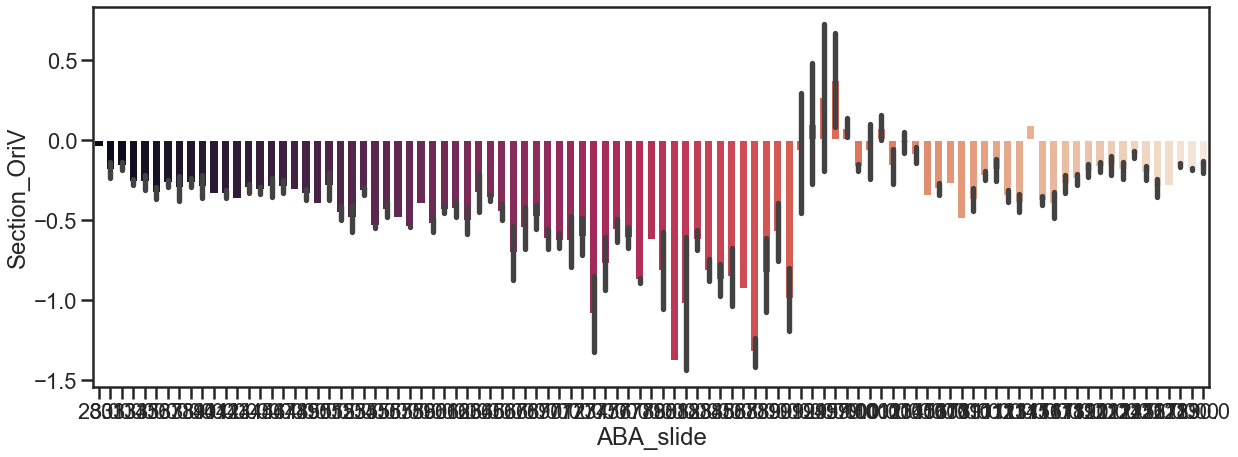

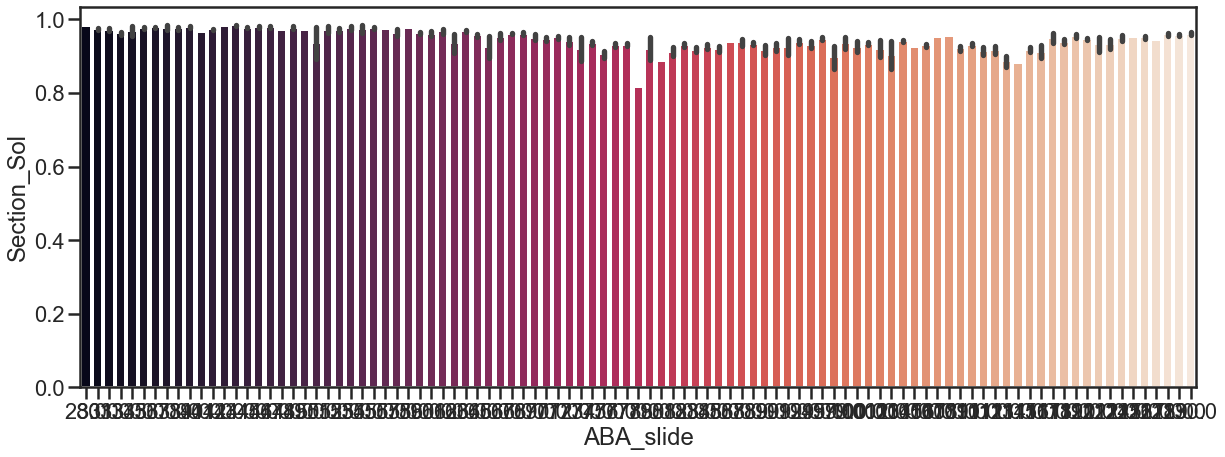

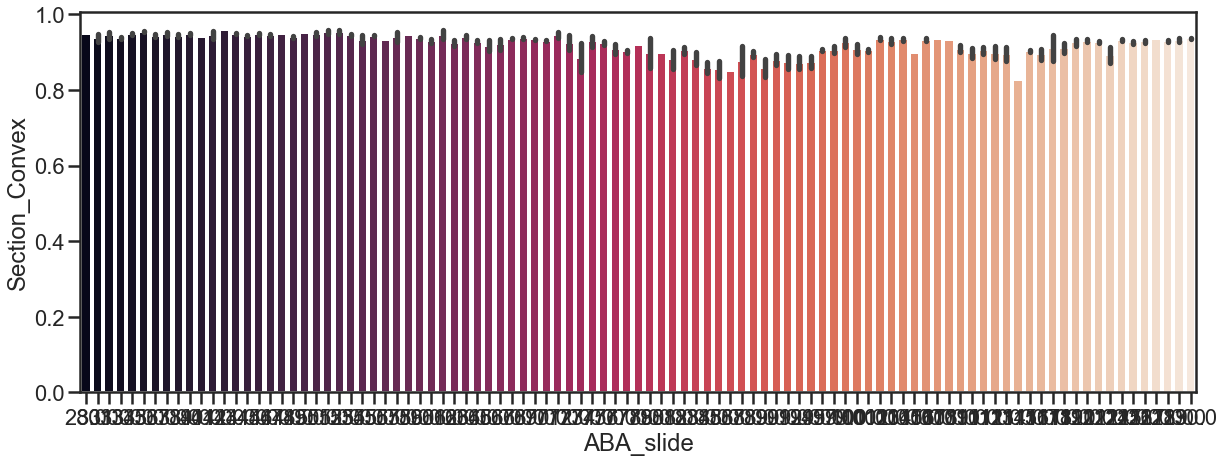

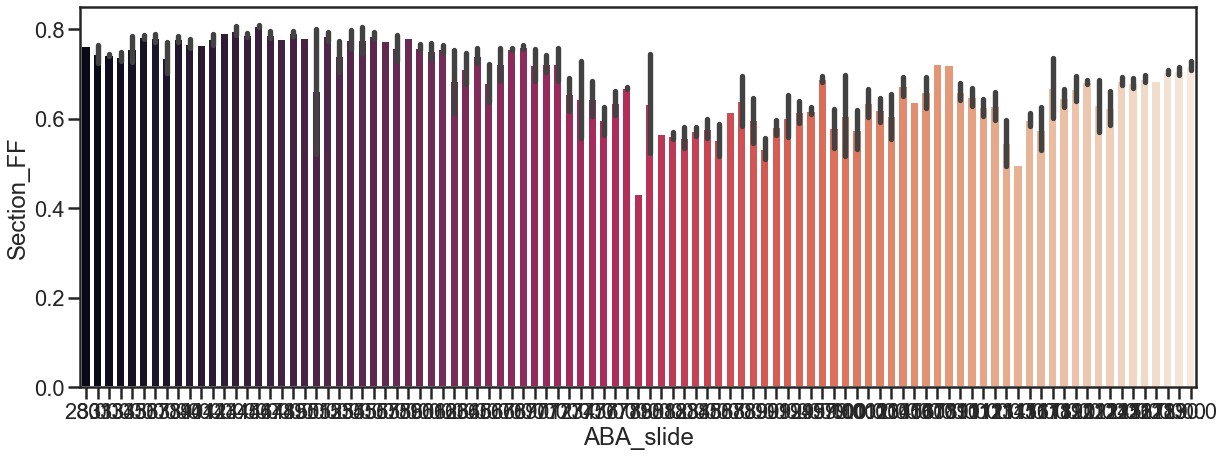

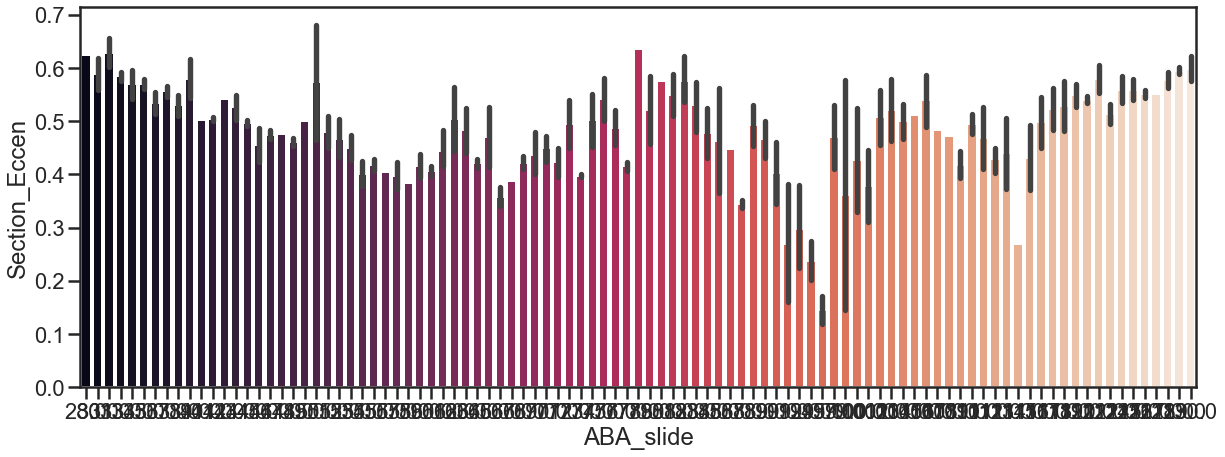

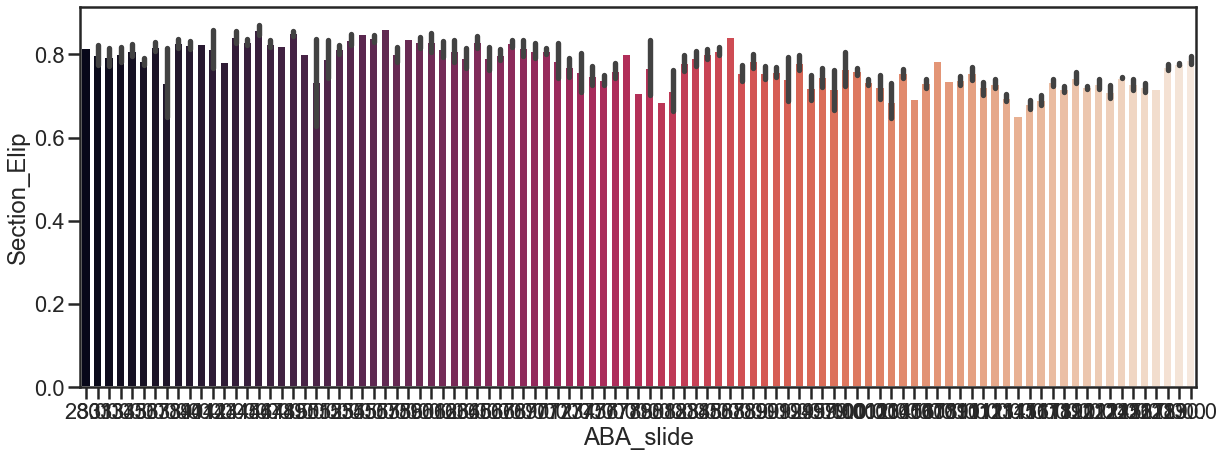

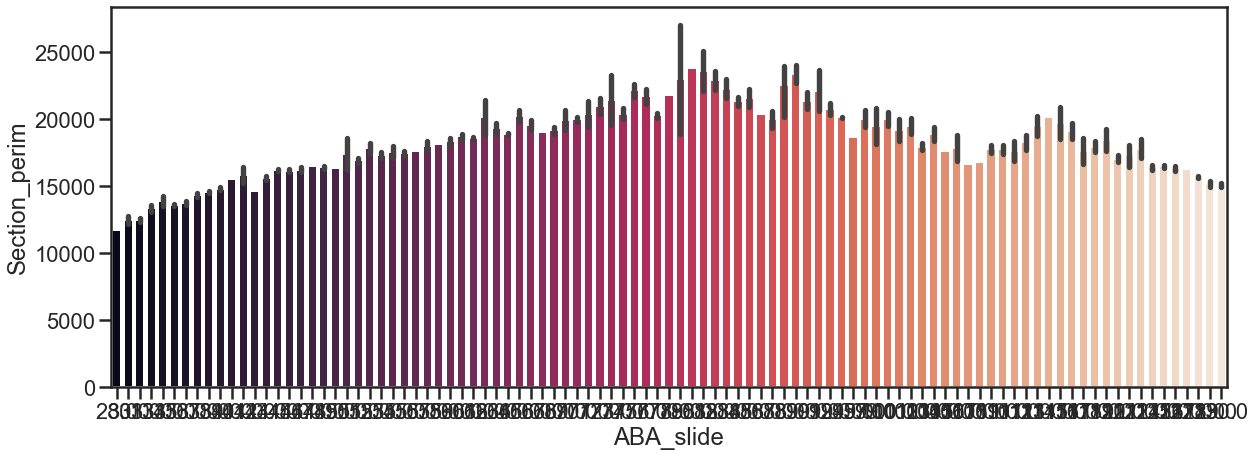

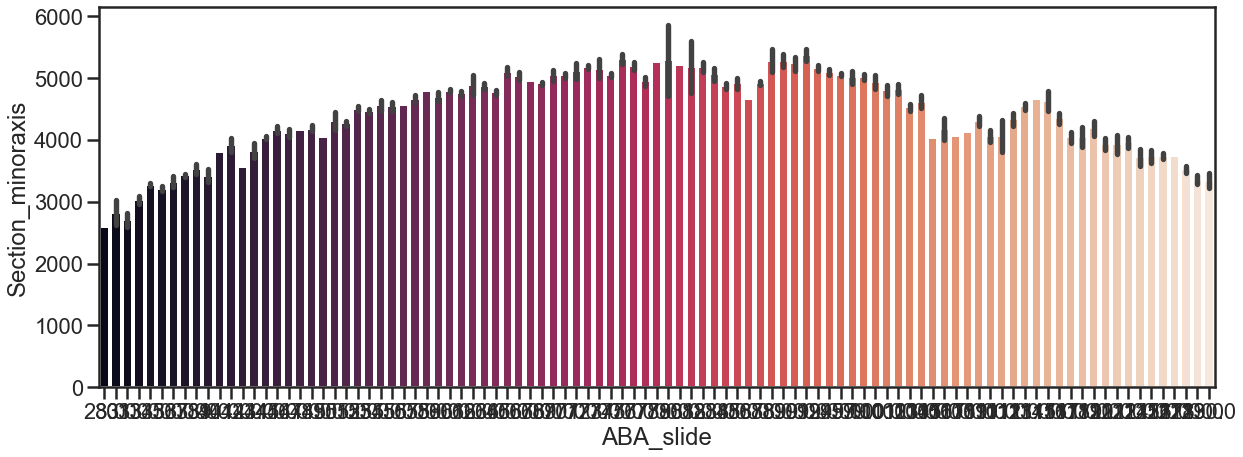

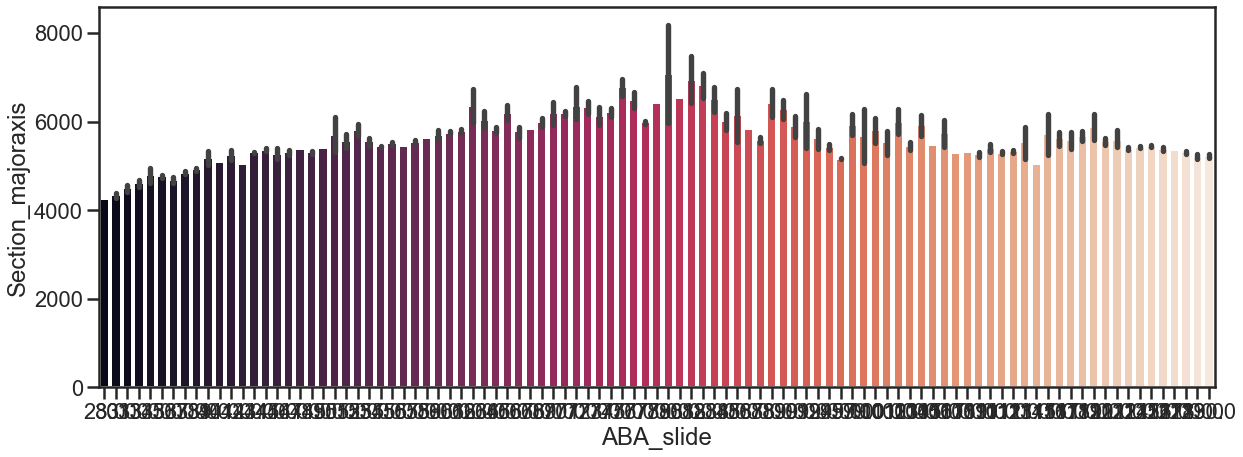

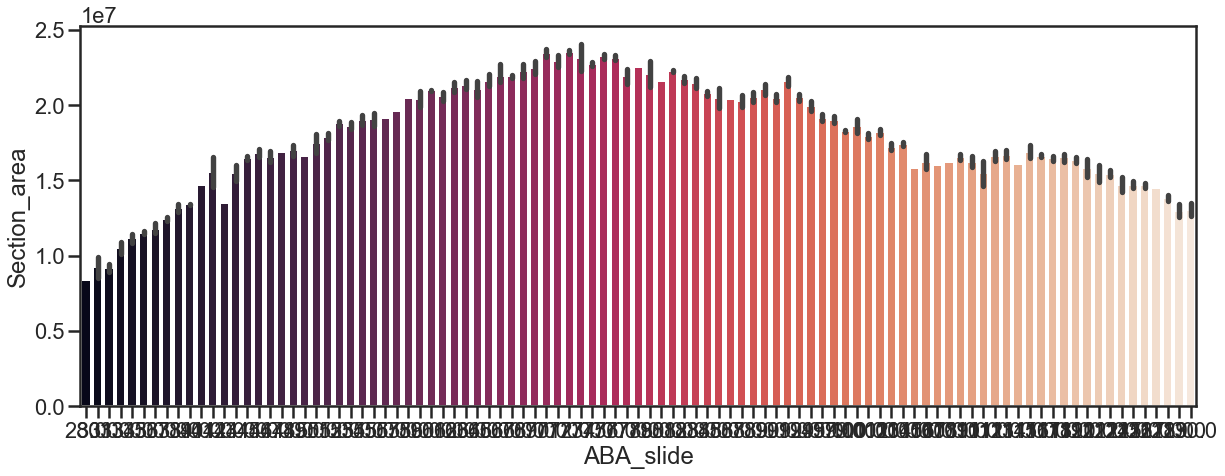

In [80]:
cols = ['Section_OriH', 'Section_OriV', 'Section_Sol', 'Section_Convex', 'Section_FF', 
        'Section_Eccen', 'Section_Elip', 'Section_perim', 'Section_minoraxis', 'Section_majoraxis', 'Section_area']

for variable in cols:
    try:
        plt.figure(figsize=(20,7))
        g = sns.barplot(x='ABA_slide', y=variable, data=data_final, ci=68, palette="rocket")
        plt.show()
    except:
        pass

### Predict ABA slide number

In [16]:
data_predict = data_final.dropna()
print(data_predict.shape)

#split data
train, test = train_test_split(data_predict, test_size = .3, random_state=39)

Y_train = train['ABA_slide']
Y_test = test['ABA_slide']

#create feature sets
features = ['Section_OriH', 'Section_OriV', 'Section_Sol', 'Section_Convex', 'Section_FF', 
            'Section_Eccen', 'Section_Elip', 'Section_perim', 'Section_minoraxis', 
            'Section_majoraxis', 'Section_area']

X_train = train[features]
X_test = test[features]

#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=10)

(384, 16)


In [66]:
#scale data 
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)

#classifier algos
dm = DummyRegressor()
lr = linear_model.LinearRegression()
rg = linear_model.Ridge()
rf = RandomForestRegressor(random_state=39)
knn = neighbors.KNeighborsRegressor()
bay = linear_model.BayesianRidge()
svr = svm.SVR()

model = knn 

#generate cross-val sets
cv = list(strat_k_fold.split(train_scaled, Y_train))
    
mean_squared_error = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='neg_mean_absolute_error')
print('mean_squared_error = ', mean_squared_error.mean())
r2 = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='r2')
print('r2 = ', r2.mean())
explained_variance = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='explained_variance')
print('explained_variance = ', explained_variance.mean())

model.fit(train_scaled, Y_train)
print('\n')

#evaluate on test set
y_pred = model.predict(test_scaled)
print('r2 = ', metrics.r2_score(Y_test, y_pred))
print('explained_variance = ',metrics.explained_variance_score(Y_test, y_pred))
print('mean_absolute_error = ', metrics.mean_absolute_error(Y_test, y_pred))

mean_squared_error =  -5.694330484330485
r2 =  0.8218386532262887
explained_variance =  0.8261359134719068


r2 =  0.9079169089701363
explained_variance =  0.9090897791358948
mean_absolute_error =  4.682758620689656


In [74]:
r2_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(train_scaled, Y_train)  #fit the model
    y_pred=model.predict(test_scaled) #make prediction on test set
    r2 = metrics.r2_score(Y_test, y_pred) #calculate r2
    r2_val.append(r2) #store r2 values
    print('r2 value for k= ' , K , 'is:', r2)

r2 value for k=  1 is: 0.8422750236588349
r2 value for k=  2 is: 0.8915019268207581
r2 value for k=  3 is: 0.8896534582160015
r2 value for k=  4 is: 0.8959884001890586
r2 value for k=  5 is: 0.9079169089701363
r2 value for k=  6 is: 0.8972572111378327
r2 value for k=  7 is: 0.9011954333638482
r2 value for k=  8 is: 0.8904578382241221
r2 value for k=  9 is: 0.8779775940445913
r2 value for k=  10 is: 0.8688847700735979
r2 value for k=  11 is: 0.8664978981641804
r2 value for k=  12 is: 0.8616909209739336
r2 value for k=  13 is: 0.8590083760264892
r2 value for k=  14 is: 0.8658894673983302
r2 value for k=  15 is: 0.8662715919150398
r2 value for k=  16 is: 0.8601363392279213
r2 value for k=  17 is: 0.8475045401209024
r2 value for k=  18 is: 0.844799609231469
r2 value for k=  19 is: 0.852154188595301
r2 value for k=  20 is: 0.843327711009056
r2 value for k=  21 is: 0.8437542913761638
r2 value for k=  22 is: 0.8387135588960113
r2 value for k=  23 is: 0.8336379902994482
r2 value for k=  24 is:

<AxesSubplot:>

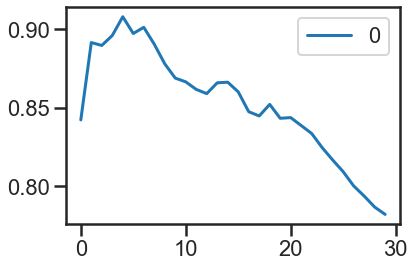

In [75]:
#plotting the rmse values against k values
curve = pd.DataFrame(r2_val) #elbow curve 
curve.plot()

In [76]:
model.fit(train_scaled, Y_train)
print('\n')

explainer = shap.KernelExplainer(model.predict, train_scaled)
shap_values = explainer.shap_values(train_scaled)

Using 268 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/268 [00:00<?, ?it/s]

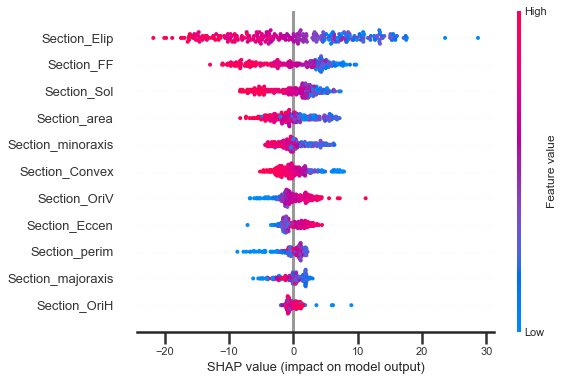

In [77]:
shap.summary_plot(shap_values, X_train)